# Learning An Egocentric SBM Kernel for the UK

The aim of this notebook is to provide an end-to-end pipeline that learns an `EgocentricSBM` for the UK using egocentric surveys from Understanding Society, and computes the Social Access Statistic for various Local Authorities (LAs) using the Census data from 2011.

## UK Census Microdata Analysis

In this section we look at the [microdata](https://census.ukdataservice.ac.uk/use-data/guides/microdata.aspx) available for UK Census 2011. In particular, the England-Wales dataset which has 2.8 million samples. We wish to look at key Blau dimensions of interest, so that we can align our own survey's design along with the census. Also, using microdata gives us the full testing distribution of the population, instead of one that is factorized over the Blau dimenions.

Different kinds of microdata have been made available (w/o a special license) corresponding to different geographical granularity. We consider the dataset at the local authority level (also referred to as boroughs in London, and council areas in Scotland). The dataset is available at a *grouped* LA level, wherein a few LAs can be grouped such that each grouped-LA contains roughly 120,000 people.

First, we write a function to import any census microdata file.

In [1]:
%matplotlib inline

In [4]:
def import_data(name=('2011', 'ew'), memory_map=True, datapath='./census/'):
    import pandas as pd
    datadict = {(2001, 'isar'):'UKDA-7205-tab/tab/01uklicind-20061002.tab',
                (2001, 'sam'):'UKDA-7207-tab/tab/01uklicsam-20070301.tab',
                (2011, 'ew'):'UKDA-7682-tab/tab/recodev12.tab',
                (2011, 'n'):'UKDA-7770-tab/tab/ni_safeguarded_la.tab',
                (2011, 's'):'UKDA-7835-tab/tab/safeguarded_grouped_la.tab'
               }
    geogdict = {(2001, 'isar'):'region',
                (2001, 'sam'):'lacode',
                (2011, 'ew'):'la_group',
                (2011, 'n'):'LA_CODE_14',
                (2011, 's'):'COUNCIL_AREA_GROUP'
               }
    datapath += datadict[name]
    df = pd.read_csv(datapath, memory_map=memory_map, sep='\t')
    df.rename(columns={geogdict[name]:'geocode'}, inplace=True)
    return df

In [5]:
data_2011_ew = import_data((2011, 'ew'))
print(data_2011_ew.shape)

(2848149, 121)


We would also like to import a dictionary which has names of the GLAs, so that they can be plotted appropriately.

In [6]:
def import_geo_dict(name=('2011', 'ew'), region=None, datapath='./census/'):
    datadict = {(2001, 'isar'):'UKDA-7205-tab/tab/geography',
                (2001, 'sam'):'UKDA-7207-tab/tab/geography',
                (2011, 'ew'):'UKDA-7682-tab/tab/geography',
                (2011, 'n'):'UKDA-7770-tab/tab/geography',
                (2011, 's'):'UKDA-7835-tab/tab/geography'
               }
    if region is not None: datapath += datadict[name]+'_'+region+'.txt'
    else: datapath += datadict[name]+'.txt'
    with open(datapath, 'r') as fd:
        geo = [x.strip() for x in fd.readlines()]
    flag = ['\t' in x for x in geo]
    if all(flag):
        geo = [x.split('\t') for x in geo]
        return dict([(x[1], int(x[0])) for x in geo])
    elif any(flag): raise RuntimeError('file formatting is inconsistent; check tabs')
    else: return dict(zip(geo, range(1, len(geo)+1)))

In [7]:
ew_geo_dict = import_geo_dict((2011, 'ew'))
lon_geo_dict = import_geo_dict((2011, 'ew'), 'l')

We define a helper function to estimate "mean" value (for continuous/ordinal) or "normalised counts" (for discrete/categorical) of attributes, over geography.

In [37]:
def attribute_by_geo(df, attribute, mean=False, ignore=[-9]):
    from numpy import nan
    df_oi = df[['geocode', attribute]].replace({attribute: dict(zip(ignore, [nan for i in ignore]))})
    df_oi = df_oi.groupby('geocode')[attribute]
    if mean: df_oi = df_oi.mean()
    else: df_oi = df_oi.value_counts()/df_oi.count() #normalized counts
    return df_oi

## Understanding Society Data Parsing

We previously took a look at the Understanding Society data, and many of its variables of interest. In this notebook, we try to align USoc with the Census data, so that we can estimate the social access statistic for LAs. First, we import USoc data for wave 3, which has information on people's local social networks.

In [9]:
def import_usoc_data(category='ukhls', wave=3, survey='indresp', datapath='./usoc/'):
    datadict = {'ukhls':'UKDA-6614-tab/tab/ukhls_w', 
                'bhps':'UKDA-6614-tab/tab/bhps_w', 
                'nurse':'UKDA-7251-tab/tab/', 
                'ip':'UKDA-6849-tab/tab/'}
    from string import ascii_lowercase
    prefix = {'bhps':str(wave)+'/', 'ukhls':str(wave)+'/', 'nurse':'', 'ip':''}
    suffix = {'bhps':'', 'ukhls':'', 'nurse':'_ns', 'ip':'_ip'}
    wave_num2sym = {'bhps': dict(zip(range(1,19), ['b'+s+'_' for s in ascii_lowercase[0:18]])), 
                 'ukhls': dict(zip(range(1,8), [s+'_' for s in ascii_lowercase[0:7]])), 
                 'ip': dict(zip(range(1,11), [s+'_' for s in ascii_lowercase[0:10]])),
                 'nurse': {2:'b',3:'c'}}
    if isinstance(wave, int): wave_sym = wave_num2sym[category][wave]
    else: wave_sym = wave
    datapath = datapath + datadict[category] + prefix[category] + wave_sym + survey + suffix[category] + '.tab'
    from pandas import read_csv
    return {'cat':category, 'wav':wave, 'sym':wave_sym, 'svy':survey, 'tab':read_csv(datapath, sep='\t')}

In [10]:
data_wave3 = import_usoc_data(wave=3)

Next, we right functions that will extract and align the USoc and Census datasets.

In [11]:
def extract_usoc(data):
    import numpy as np
    from pandas import concat
    
    if data['cat']!='ukhls': 
        print('please use a ukhls dataset')
        return
             
    var = {'sex_dv':'sex',
           'netsx':'sex_nom',
           'age_dv':'age',
           'simage':'age_prop',
           'netag':'age_nom',
           'racel_dv':'ethnicity',
           'simrace':'ethnicity_prop',
           'netet':'ethnicity_nom',
           'qfhigh_dv':'education',
           'simeduc':'education_prop',
           'jbstat':'employment',
           'simjob':'employment_prop',
           'netjb':'employment_nom',
           'fimngrs_dv':'income',
           'siminc':'income_prop',
           'simarea':'distance_prop',
           'netlv':'distance_nom',
           'simfam':'family_prop',
           'closenum':'num_friends'
          }
    
    var_encoding = {'sex':{1:'male',
                           2:'female', 
                           (-10, -9, -8, -7, -2, -1, 0):np.nan},
                    'ethnicity':{1:'british-white', 
                                 (2, 3, 4):'other-white',
                                 (5, 6, 14, 15, 16):'black',
                                 (7, 8, 12, 13):'other-asian',
                                 (9, 10, 11):'south-asian',
                                 #11:'bangladeshi',
                                 #13:'other-asian',
                                 (17, 97):'other-ethnicity',
                                 (-10, -9, -8, -7, -2, -1):np.nan
                                },
                    'education':{(1, 2, 3, 4, 5, 6):'level-4',
                                 (7, 8, 9):'level-3',
                                 (10, 11, 12, 13):'level-2',
                                 (14, 15, 16):'level-1',
                                 96:'level-0',
                                 (-10, -9, -8, -7, -2, -1):np.nan
                                },
                    'employment':{(1, 2, 5, 10, 11, 97):'employed',
                                  3:'unemployed',
                                  4:'retired', 
                                  6:'housework', 
                                  (7, 9):'student',
                                  (8, -10, -9, -8, -7, -2, -1):np.nan
                                 },
                    'employment_nom':{(1, 2):'employed', 
                                      3:'unemployed', 
                                      4:'student',
                                      5:'housework', 
                                      6:'retired',
                                      (-10, -9, -8, -7, -2, -1):np.nan
                                     },
                    'distance_nom':{(1, 2):'similar', 
                                    (3, 4, 5):'dissimilar', 
                                    (-10, -9, -8, -7, -2, -1):np.nan
                                   }
                    }
    
    def expand_var(var_dict, prefix='', num_nom=3):
        new_dict = dict()
        for key, value in var_dict.items():
            if key[:3]=='net':
                for i in range(1, num_nom+1): new_dict[prefix+key+'_'+str(i)] = value+'_'+str(i)
            else: new_dict[prefix+key] = value
        return new_dict
    
    def expand_encoding(encoding_dict, atts=[], num_nom=3):
        new_dict = dict()
        for key, value in encoding_dict.items():
            new_d = dict()
            for k, v in value.items():
                if not hasattr(k, '__iter__'): k = (k,)              
                for i in k: new_d[i] = v
            if key[-4:]=='_nom':
                for i in range(1, num_nom+1):
                    new_dict[key+'_'+str(i)] = new_d
            else:
                new_dict[key] = new_d
                if key in atts and key+'_nom' not in encoding_dict:
                    for i in range(1, num_nom+1):
                        new_dict[key+'_nom_'+str(i)] = new_d
        return new_dict
    
    def define_prop(x):
        if x==1: return 1
        elif x==2: return 3/4
        elif x==3: return 1/2
        elif x==4: return 1/4
        else: return np.nan
        
    def derive_prop(df, atts=[], num_nom=3):
        if not hasattr(atts, '__iter__'): atts = [atts]
        dfs = list()
        col = list()
        self_atts = set(df)
        for att in set(atts):
            if att in self_atts:
                idx = df[att].notnull()
                friends = df[['_'.join([att, 'nom', str(i)]) for i in range(1, num_nom+1)]][idx]
                dfs.append((friends.eq(df[att][idx], axis=0) & friends.notna()).sum(axis=1)/(friends.notna().sum(axis=1)))
            else:
                friends = df[['_'.join([att, 'nom', str(i)]) for i in range(1, num_nom+1)]]
                dfs.append(friends.eq('similar').sum(axis=1)/(friends.notna().sum(axis=1)))
            col.append(att+'_prop_dv')
        dfs = concat(dfs, axis=1)
        dfs.columns = col
        return dfs
    
    def classify_age(x, granularity=20):
        if np.isnan(x) or x < 16: return np.nan
        else: return min(x, 99)//granularity*granularity
        
    def classify_age_static(x): #http://www.pgagroup.com/standardized-survey-classifications.html
        if np.isnan(x) or x < 16: return np.nan
        elif 16 <= x < 25: return 20.0
        elif 25 <= x < 35: return 30.0
        elif 35 <= x < 45: return 40.0
        elif 45 <= x < 55: return 50.0
        elif 55 <= x < 65: return 60.0
        else: return 70.0
        
    def classify_income(x):
        if np.isnan(x): return np.nan
        elif x <= 584: return 'DE'
        elif x <= 1342: return 'C2'
        elif x <= 2115: return 'C1'
        else: return 'AB'
    
    if data['sym']=='x': prefix = ''
    else: prefix = data['sym']
    var = expand_var(var, prefix)
    out = data['tab'].loc[:,var.keys()]
    out.index = data['tab']['pidp']
    out.rename(columns=var, inplace=True)
    var_encoding = expand_encoding(var_encoding, atts=['sex', 'ethnicity'])
    out.replace(to_replace=var_encoding, inplace=True)
    out.loc[out['employment']=='unemployed','employment_prop'] = 1-out.loc[out['employment']=='unemployed','employment_prop'] 
    out['age_raw'] = out['age']
    #out['age'] = out['age'].apply(classify_age)
    out['age'] = out['age'].apply(classify_age_static)
    out['income_raw'] = out['income']
    out['income'] = out['income'].apply(classify_income)
    for i in range(1, 4):
        out['age_raw_nom_'+str(i)] = out['age_nom_'+str(i)]
        #out['age_nom_'+str(i)] = out['age_nom_'+str(i)].apply(classify_age)
        out['age_nom_'+str(i)] = out['age_nom_'+str(i)].apply(classify_age_static)
    for var_name in list(out):
        if var_name[-5:]=='_prop': out[var_name] = out[var_name].apply(define_prop)
    out[out._get_numeric_data()<0] = np.nan
    out = concat([out, derive_prop(out, atts=['sex', 'age', 'ethnicity', 'employment', 'distance'])], axis=1)
    out.dropna(axis=1, how='all', inplace=True)
    return out

In [12]:
data_wave3_atts = extract_usoc(data_wave3)

In [13]:
def extract_census(data):
    import numpy as np
    
    var = {'sex':'sex',
           'ageh':'age',
           'ethnicityew':'ethnicity',
           'hlqupuk11':'education',
           'ecopuk11':'employment',
           'scgpuk11c':'income',
           'religionew':'religion',
           'mainglangg':'language',
           'geocode':'geocode'
          }
    
    var_encoding = {'sex':{1:'male',
                           2:'female', 
                           -9:np.nan
                          },
                    'ethnicity':{1:'british-white', 
                                 (2, 3):'other-white',
                                 (4, 11, 12):'black',
                                 (5, 9, 10):'other-asian',
                                 (6, 7, 8):'south-asian',
                                 #8:'bangladeshi',
                                 #10:'other-asian',
                                 13:'other-ethnicity',
                                 -9:np.nan
                                },
                    'education':{10:'level-0',
                                 11:'level-1',
                                 (12, 13, 16):'level-2',
                                 14:'level-3',
                                 15:'level-4',
                                 -9:np.nan
                                },
                    'employment':{(1, 2, 3, 4, 7):'employed',
                                  (5, 6):'unemployed',
                                  (8, 9, 11):'student',
                                  10:'retired',
                                  12:'housework',
                                  (13, 14, -9):np.nan
                                 },
                    'income':{1:'AB',
                              2:'C1',
                              3:'C2',
                              4:'DE',
                              -9:np.nan
                             },
                    'religion':{1:'atheist',
                                2:'christian',
                                3:'buddhist',
                                4:'hindu',
                                5:'jewish',
                                6:'muslim',
                                7:'sikh',
                                8:'other-religion',
                                (9, -9):np.nan
                               },
                    'language':{1:'english/welsh',
                                2:'polish',
                                3:'punjabi',
                                4:'urdu',
                                5:'bengali',
                                6:'gujarati',
                                7:'arabic',
                                8:'french',
                                9:'other-language',
                                -9:np.nan
                               }
                   }
    
    def expand_encoding(encoding_dict):
        new_dict = dict()
        for key, value in encoding_dict.items():
            new_d = dict()
            for k, v in value.items():
                if not hasattr(k, '__iter__'): k = (k,)              
                for i in k: new_d[i] = v
            new_dict[key] = new_d
        return new_dict
    
    def decode_age(x):
        return (x-0.5)*5
        
    def classify_age(x, granularity=20):
        if np.isnan(x) or x < 4: return np.nan
        else: return ((x-0.5)*5)//granularity*granularity
        
    def classify_age_static(x): #http://www.pgagroup.com/standardized-survey-classifications.html
        if np.isnan(x) or x < 16: return np.nan
        elif 16 <= x < 25: return 20.0
        elif 25 <= x < 35: return 30.0
        elif 35 <= x < 45: return 40.0
        elif 45 <= x < 55: return 50.0
        elif 55 <= x < 65: return 60.0
        else: return 70.0
    
    out = data.loc[:,var.keys()]
    out.rename(columns=var, inplace=True)
    var_encoding = expand_encoding(var_encoding)
    out.replace(to_replace=var_encoding, inplace=True)
    out['age_raw'] = out['age'].apply(decode_age)
    #out['age'] = out['age'].apply(classify_age)
    out['age'] = out['age_raw'].apply(classify_age_static)
    out[out._get_numeric_data()<0] = np.nan
    out.dropna(axis=1, how='all', inplace=True)
    return out

In [14]:
data_c2011_atts = extract_census(data_2011_ew)

## Generating SBM from USoc

Now that we have parsed and aligned USoc-Census data, we are ready to learn the SBM. $\rho$s are derived from prop-type questions for `education` and `income`, and `nom2prop` for `sex`, `age`, `ethnicity` and `employment`. The $\omega$s are derived from the response of the question "how many close friends do you have?". And $\pi$s are derived from simple counts, **not from USoc but the census**, since the latter is more representative.

In [15]:
def nom2prop(df, atts=['sex', 'age', 'ethnicity', 'employment', 'distance'], group=True, num_nom=3):
    if not hasattr(atts, '__iter__') or isinstance(atts, str): atts = [atts]
    dvs = dict()
    self_atts = set(df)
    for att in set(atts):
        if att in self_atts:
            if group:
                dvs[att] = dict()
                for name, data in df.groupby(att):
                    idx = data[att].notnull()
                    friends = data[['_'.join([att, 'nom', str(i)]) for i in range(1, num_nom+1)]][idx]
                    dvs[att][name] = (friends.eq(data[att][idx], axis=0) & friends.notna()).sum(axis=1).sum()/friends.notna().sum(axis=1).sum()
            else:
                idx = df[att].notnull()
                friends = df[['_'.join([att, 'nom', str(i)]) for i in range(1, num_nom+1)]][idx]
                dvs[att] = (friends.eq(df[att][idx], axis=0) & friends.notna()).sum(axis=1).sum()/friends.notna().sum(axis=1).sum()
        else:
            friends = df[['_'.join([att, 'nom', str(i)]) for i in range(1, num_nom+1)]]
            dvs[att] = friends.eq('similar').sum(axis=1).sum()/friends.notna().sum(axis=1).sum()
    return dvs    

In [16]:
def generate_sbm_params(df, df_pi=None, prop=['education', 'income'], prop_dv=[], prop_dv_global=['sex', 'age', 'ethnicity', 'employment'], ignore_family=True):
    if df_pi is None: df_pi = df
    all_atts = list(df)
    prop = dict([(i, i+'_prop') for i in prop if i in all_atts and i+'_prop' in all_atts])
    prop_dv = dict([(i, i+'_prop_dv') for i in prop_dv if i not in prop and i in all_atts and i+'_prop_dv' in all_atts])
    print('using prop for dims:', set(prop.keys()))
    print('using prop-dv for dims:', set(prop_dv.keys()))
    prop.update(prop_dv)
    prop_dv_global = set([i for i in prop_dv_global if i not in prop and i in all_atts and i+'_nom_1' in all_atts])
    print('using prop-dv-global for dims:', prop_dv_global)
    prop_dv_global = nom2prop(df, prop_dv_global)
    dimnames = []
    pis = []
    rhos = []
    omegas = []
    meanomegas = []
    for dim in list(prop.keys())+list(prop_dv_global.keys()):
        df_given_dim = df.groupby(dim)
        names = []
        pi = []
        rho = []
        omega = []
        tot = 0
        for name, data in df_given_dim:
            names.append(name)
            pi.append(df_pi[df_pi[dim]==name].size)
            if dim in prop: rho.append(data[prop[dim]].mean())
            else: rho.append(prop_dv_global[dim][name])
            if ignore_family: omega.append((data['num_friends']*(1-data['family_prop'])).mean())
            else: omega.append(data['num_friends'].mean())
            tot += pi[-1]
        pi = [p/tot for p in pi]
        dimnames.append((dim, names))
        pis.append(pi)
        rhos.append(rho)
        omegas.append(omega)            
        meanomegas.append(sum([(o*p) for o,p in zip(omega, pi)]))
    mo = sum(meanomegas)/len(meanomegas)
    print('mean omega', mo)
    for i in range(len(omegas)):
        for j in range(len(omegas[i])):
            omegas[i][j] *= mo/meanomegas[i] #a *small* correction to ensure mean omega is same across all dimensions
    return {'shape':[len(i) for i in pis], 'name':dimnames, 'pi':pis, 'rho':rhos, 'omega':omegas}    

In [17]:
sbm_params = generate_sbm_params(data_wave3_atts, data_c2011_atts)

using prop for dims: {'income', 'education'}
using prop-dv for dims: set()
using prop-dv-global for dims: {'employment', 'ethnicity', 'sex', 'age'}
mean omega 3.2888192631722872


Let us import the `EgocentricSBM` class and explore the learnt SBM. (See the egosbm notebook for more details on this class.)

In [18]:
from egosbm import EgocentricSBM

In [19]:
#sbm = EgocentricSBM(shape=sbm_params['shape'], dims=sbm_params['name'], name='usoc_wave3_pic2011')
#sbm.set_pi(sbm_params['pi'])
#sbm.set_rho(sbm_params['rho'])
#sbm.set_omega(sbm_params['omega'])
#sbm.sort()
#sbm.save()
sbm = EgocentricSBM(filepath='usoc_wave3_pic2011.ego')

In [20]:
print(sbm)

name:         usoc_wave3_pic2011
ndim:         6
shape:        (6, 6, 5, 5, 4, 2)
              
|dims|        |blocks|
ethnicity     ('british-white', 'other-white', 'south-asian', 'black', 'other-asian', 'other-ethnicity')
age           (70.0, 40.0, 50.0, 30.0, 20.0, 60.0)
employment    ('employed', 'retired', 'student', 'unemployed', 'housework')
education     ('level-4', 'level-2', 'level-0', 'level-1', 'level-3')
income        ('C1', 'DE', 'AB', 'C2')
sex           ('female', 'male')
              
|dims|        |pi|
ethnicity     (0.8023811978146583, 0.05614494062112331, 0.05363329056016266, 0.04377330456511771, 0.03385537928901748, 0.010211887149920556)
age           (0.19912783658502836, 0.16982452954199528, 0.16649716341497164, 0.16427416286149163, 0.1582606890826069, 0.14201561851390618)
employment    (0.5678738959320697, 0.22645735102017603, 0.09124568419344883, 0.07240438559604517, 0.04201868325826029)
education     (0.27290079261319716, 0.2457657146285904, 0.22537553537633

In [21]:
print(sbm.ishomophilous())

((True, True, True, True, True, True), (True, True, True, True, True, True), (True, True, True, True, True), (True, True, True, True, True), (True, True, True, True), (True, True))


In [22]:
#sbm_full = sbm.get_model('full', name='sbm_wave3_full')
#sbm_full.save()
sbm_full = EgocentricSBM.StochasticBlockModel(filepath='sbm_wave3_full.npz')

In [23]:
print(sbm_full)

name:        sbm_wave3_full
mode:        full
ndim:        6
shape:       (6, 6, 5, 5, 4, 2)
directed:    True
affinity:    3.2888192631722863
pi:          ((0.8023811978146583, 0.05614494062112331, 0.05363329056016266, 0.04377330456511771, 0.03385537928901748, 0.010211887149920556), (0.19912783658502836, 0.16982452954199528, 0.16649716341497164, 0.16427416286149163, 0.1582606890826069, 0.14201561851390618), (0.5678738959320697, 0.22645735102017603, 0.09124568419344883, 0.07240438559604517, 0.04201868325826029), (0.27290079261319716, 0.2457657146285904, 0.2253755353763369, 0.13261609656943063, 0.12334186081244496), (0.3028089534690654, 0.24944635412693356, 0.22681586871356707, 0.22092882369043398), (0.5078393019466327, 0.4921606980533673))
params:      (((3.3934497619831063, 1.1811576252222293, 0.2644552506560374), (3.020769262501265, 5.712557482767374, 0.7196749040920319), (2.591125141593747, 14.80035190809243, 0.21789484315512045), (2.8748335377816394, 15.168795667441648, 0.351393334

We can be interested in the "global" Social Access Statistic (SAS) for this model, with the same testing population as the training one, or a uniform one. (See the notebook on egosbm for more details.) The two values we obtain correspond to the mean SAS and variance SAS. Note that going from the current society to an "equiproportioned" one, the mean SAS increases but the variance SAS decreases.

In [24]:
print('sas full', sbm_full.sas_global())

sas full (10.985698055084814, 4.872142624945702)


In [25]:
print('sas full uni', sbm_full.sas_global(pi='uni'))

sas full uni (14.166054511315988, 2.699556337113365)


## Extracting SAS from Census

Now that we have learnt an SBM, say we are interested in the global social access statistic of different LAs of UK, or more specifically, boroughs of London. We can evaluate them by finding the "target" $\pi$ distribution in each borough.

In [26]:
def pi_by_geo(sbm, census_df, geocodes=[]):
    if not hasattr(geocodes, '__iter__'): geocodes = [geocodes]
    atts = [i[0] for i in sbm.dims if i[0] in list(census_df)]
    geo = []
    pis = []
    df = census_df[['geocode']+atts]
    for name, data in df.groupby('geocode'):
        if (len(geocodes)>0 and name in geocodes) or (len(geocodes)==0):
            geo.append(name)
            pi = data.groupby(atts).count()
            pis.append(pi/pi.sum())
    from pandas import concat
    pis = concat(pis, axis=1)
    pis.columns = geo
    n = len(geo)
    src = sbm.get_dims()
    tgt = [','.join([str(a)+':'+str(i) for (a,i) in zip(atts, idx)]) for idx in pis.index]
    pis.index = tgt
    rows = []
    import numpy as np
    from pandas import DataFrame
    for i in src:
        if i in tgt: rows.append(pis.loc[i].values)
        else: rows.append(np.zeros(n))
    pis = np.vstack(rows).transpose()
    pis[np.isnan(pis)] = 0.0
    return DataFrame(pis, index=geo, columns=src)

Next, we compute SAS by geography by using the same SBM kernel, but different testingg populations, corresponding to the respective borough.

In [27]:
def sas_by_geo(sbm_model, pi_by_geo):
    from pandas import DataFrame
    out = DataFrame([[i, *sbm_model.sas_global(pi=pi_by_geo.loc[i].values)] for i in pi_by_geo.index], columns=['geocode','sas_mean','sas_var'])
    out.set_index(pi_by_geo.index, inplace=True)
    return out

In [29]:
#test_pi_lon = pi_by_geo(sbm, data_c2011_atts, lon_geo_dict.values())
#test_pi_lon.to_csv('test_pi_lon.tsv', sep='\t')
#test_pi_uk = pi_by_geo(sbm, data_c2011_atts)
#test_pi_uk.to_csv('test_pi_uk.tsv', sep='\t')
from pandas import read_csv
test_pi_lon = read_csv('test_pi_lon.tsv', index_col=0, sep='\t')
test_pi_uk = read_csv('test_pi_uk.tsv', index_col=0, sep='\t')
print(test_pi_lon.shape, test_pi_uk.shape)

(32, 7200) (265, 7200)


We now have the full distribution across each of the 7200 (combinatorial) communities. Note that this distribution is not factorized by the Blau dimensions, even though the training distribution and thus the kernel indeed assumed independent Blau dimensions. This ensures that people who are "doubly" isolated do come across as such.

In [30]:
#sas_full_lon = sas_by_geo(sbm_full, test_pi_lon)
#sas_full_lon.to_csv('sas_meanvar_lon.tsv', sep='\t')
sas_full_lon = read_csv('sas_meanvar_lon.tsv', index_col=0, sep='\t')

In [32]:
#sas_full_uk = sas_by_geo(sbm_full, test_pi_uk)
#sas_full_uk.to_csv('sas_meanvar_uk.tsv', sep='\t')
sas_full_uk = read_csv('sas_meanvar_uk.tsv', index_col=0, sep='\t')

Let us write a helper function to make scatter plots of interesting attributes, computing Spearman's correlation coefficient between the $x$ and $y$ datapoints.

In [33]:
def plot_scatter(xdata, ydata, zdata=None, z=0, phi=45, text=None, xlab='x', ylab='y', zlab='z'):
    import matplotlib.pyplot as plt
    from scipy.stats import spearmanr
    fig = plt.figure(dpi=180)
    if z and zdata is not None:
        from mpl_toolkits.mplot3d import Axes3D
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(xdata, ydata, zdata)
        cx = [ax.get_xlim3d()[0]]*len(xdata)
        cy = [ax.get_ylim3d()[0]]*len(ydata)
        cz = [ax.get_zlim3d()[0]]*len(zdata)
        ax.scatter(xdata, ydata, cz, c=zdata, alpha=0.2, lw=0)
        ax.scatter(cx, ydata, zdata, c=xdata, alpha=0.2, lw=0)
        ax.scatter(xdata, cy, zdata, c=ydata, alpha=0.2, lw=0)
        if text is not None: [ax.text(x, y, z, t) for (x,y,z,t) in zip(xdata, ydata, zdata, text)]
        ax.set_xlabel(xlab)
        ax.set_ylabel(ylab)
        ax.set_zlabel(zlab)
        ax.view_init(z, phi)
        plt.show()
    else:
        plt.scatter(xdata, ydata, c=zdata)
        if text is not None: [plt.text(x, y, t) for (x,y,t) in zip(xdata, ydata, text)]
        rho, pval = spearmanr(xdata, ydata)
        plt.title('rho: %.2f, pval: %.2f'%(round(rho,2), round(pval,2)))
        if zdata is not None:
            cbar = plt.colorbar()
            cbar.set_label(zlab)
        plt.xlabel(xlab)
        plt.ylabel(ylab)
        plt.show()

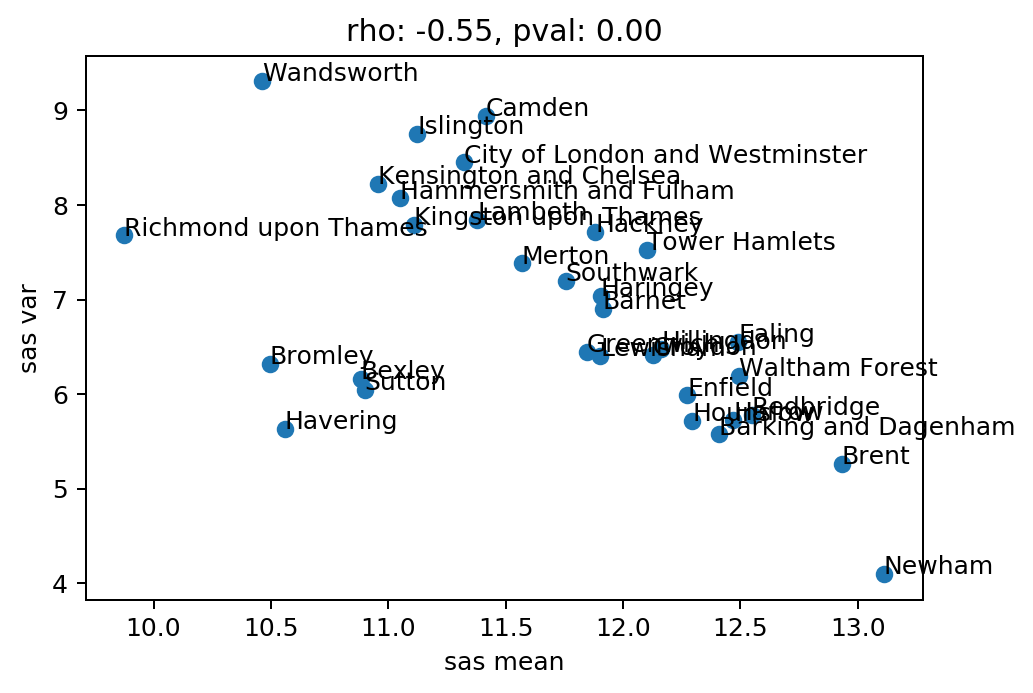

In [34]:
plot_scatter(sas_full_lon['sas_mean'], sas_full_lon['sas_var'], text=lon_geo_dict.keys(), xlab='sas mean', ylab='sas var')

For London, we notice that a low mean SAS has a higher var SAS, which suggests some kind of a trade-off between the two. (That is, better social access incurs a cost of more variance in social access.) But on looking at all of England and Wales, we notice an inverse-U shaped curve. This shows that the variance in SAS is higher in moderate mean SAS, and lower at its extremes, which would make statistical sense.

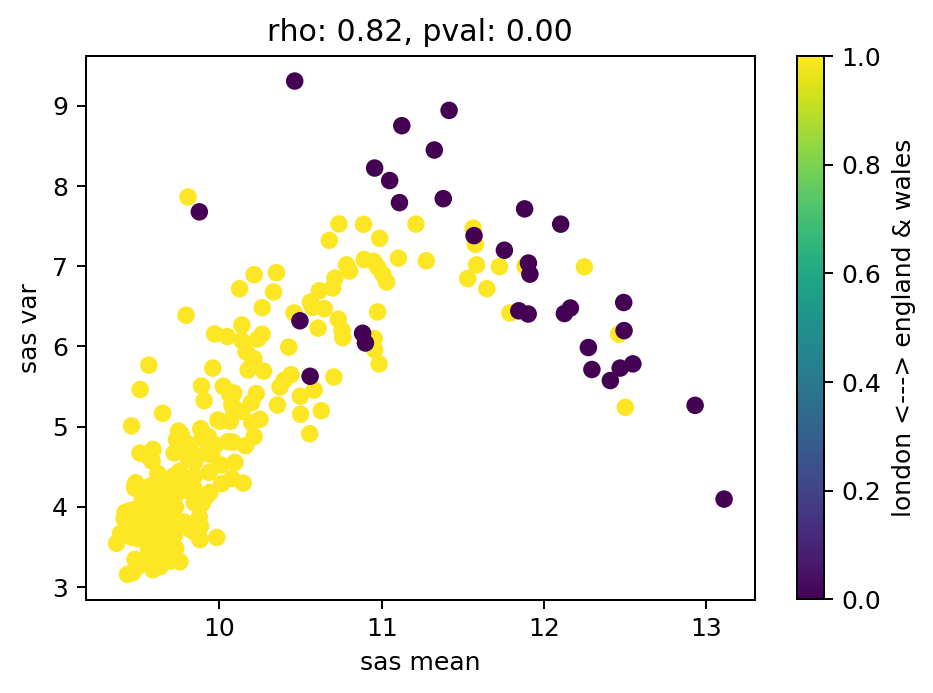

In [52]:
plot_scatter(sas_full_uk['sas_mean'], sas_full_uk['sas_var'], [0 if i in lon_geo_dict else 1 for i in ew_geo_dict], xlab='sas mean', ylab='sas var', zlab='london <---> england & wales')

Since we are interested in linking SAS to health, one quick statistic we can look at is the perceived-general-health question asked in the Census. Note that:
1. For **health**, a lower value means better health.
2. For **income**, a lower value means higher income.
3. For **age**, a higher value means higher age.
4. For **mean SAS**, a lower value means higher social access.
5. For **var SAS**, a higher value means larger variance in social access.

In [40]:
health_by_geo = attribute_by_geo(data_2011_ew, 'health', mean=True)
income_by_geo = attribute_by_geo(data_2011_ew, 'scgpuk11c', mean=True)
age_by_geo = attribute_by_geo(data_2011_ew, 'ageh', mean=True)

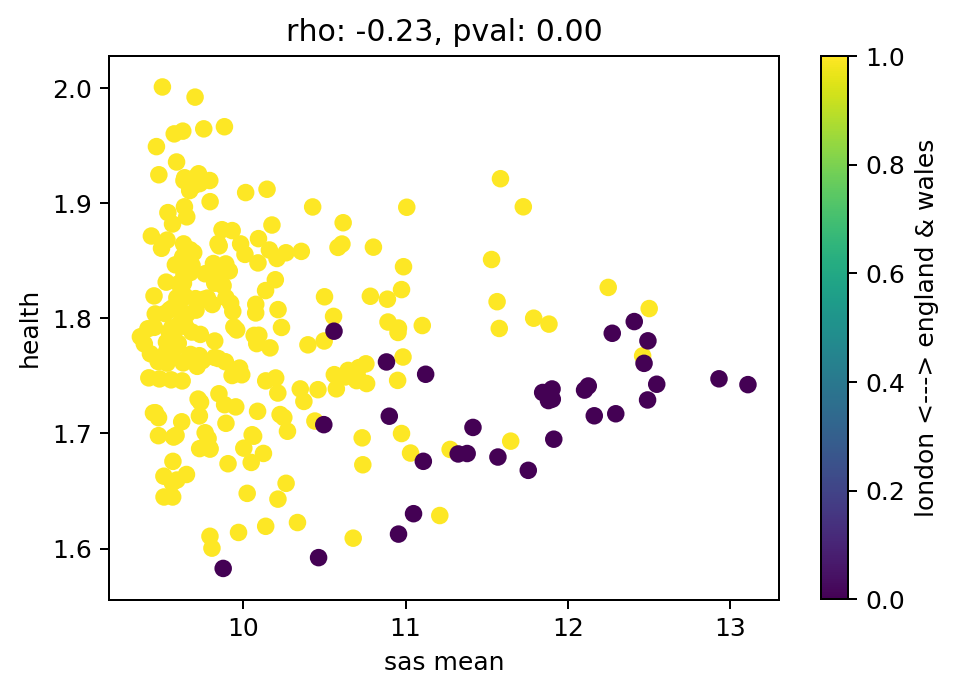

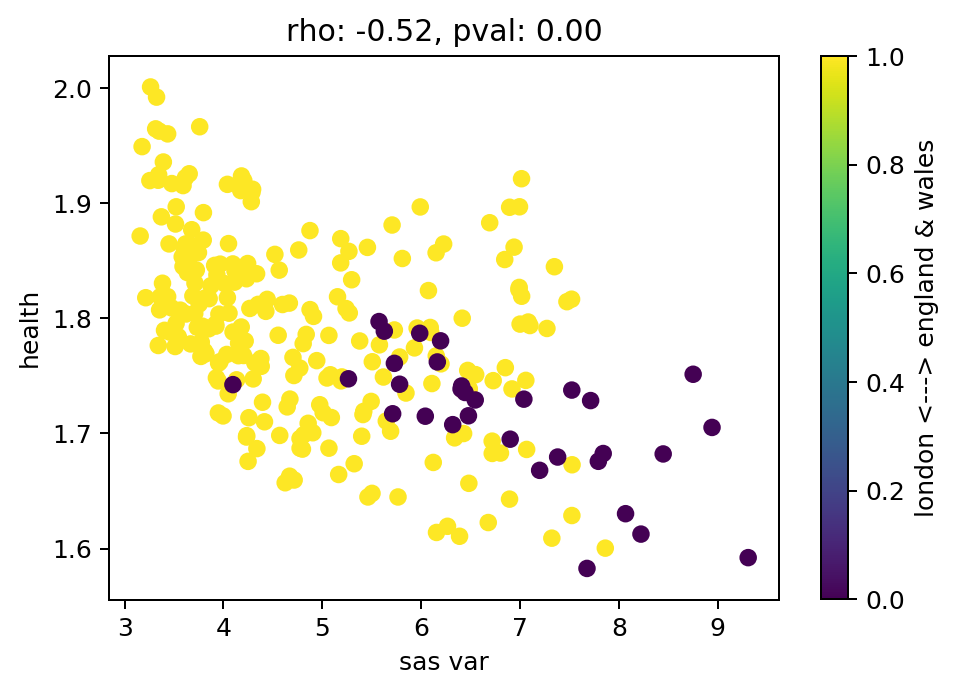

In [68]:
plot_scatter(sas_full_uk['sas_mean'], health_by_geo.values.flatten(), [0 if i in lon_geo_dict else 1 for i in ew_geo_dict], xlab='sas mean', ylab='health', zlab='london <---> england & wales')
plot_scatter(sas_full_uk['sas_var'], health_by_geo.values.flatten(), [0 if i in lon_geo_dict else 1 for i in ew_geo_dict], xlab='sas var', ylab='health', zlab='london <---> england & wales')

Clearly, var SAS seems to be more correlated with people's perceived general health. **Interestingly though, the higher the variance, the higher is people's perceived general health.** We can see this better if we focus just on London.

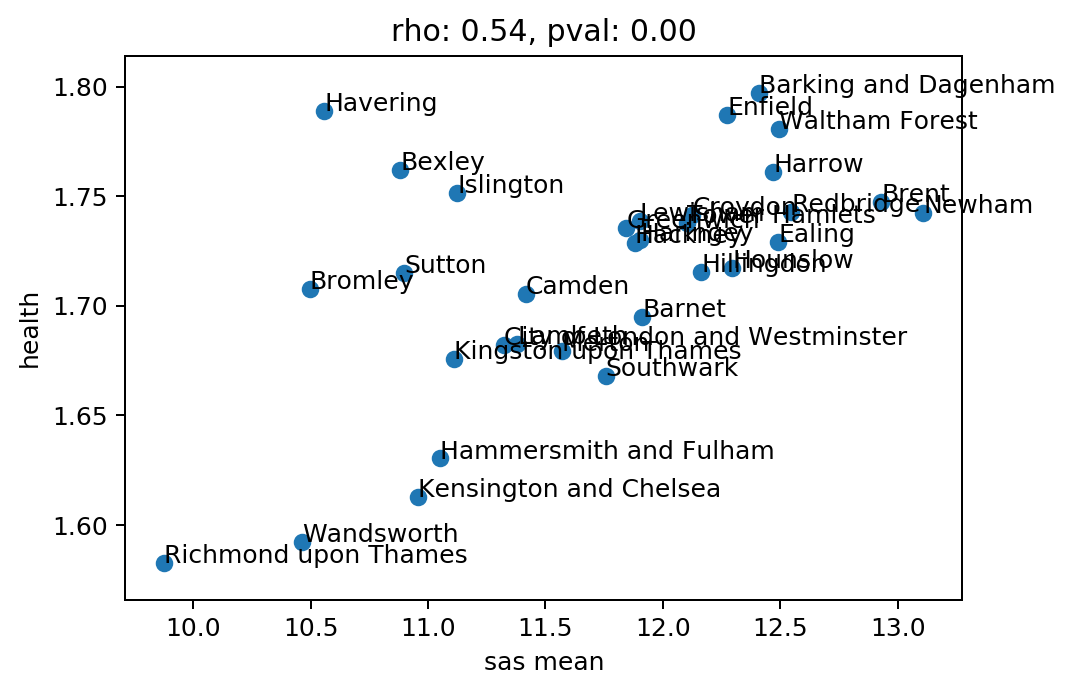

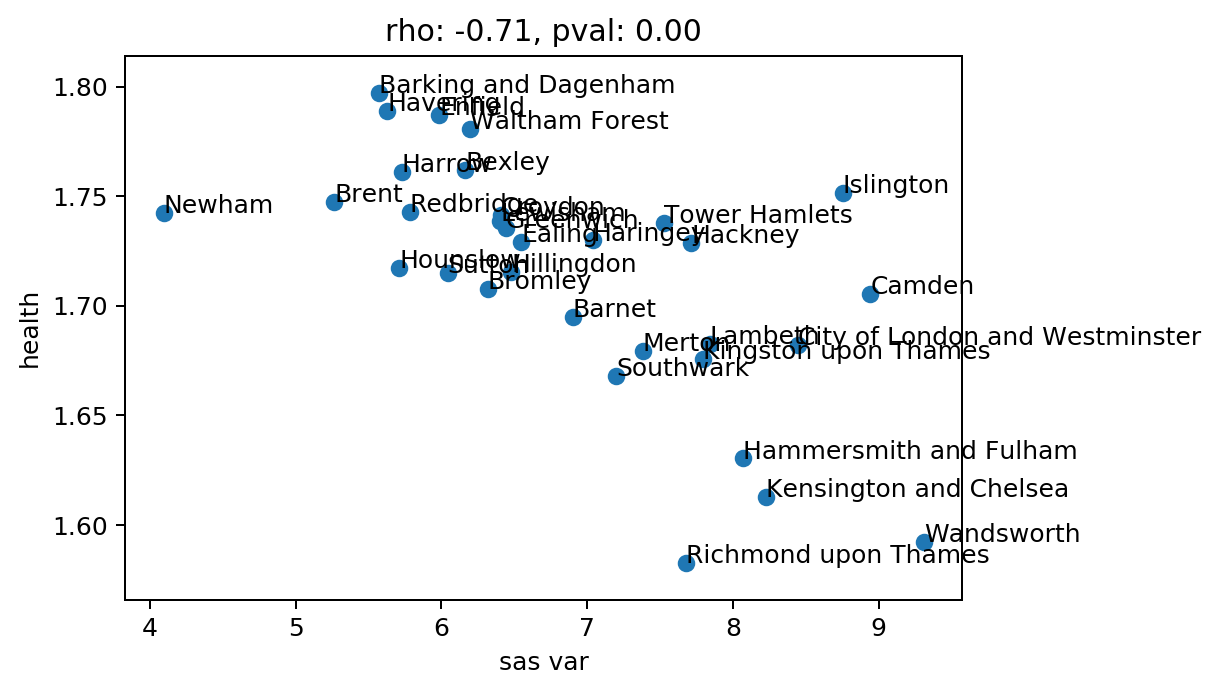

In [67]:
plot_scatter(sas_full_uk['sas_mean'][list(lon_geo_dict.values())], health_by_geo[list(lon_geo_dict.values())].values.flatten(), text=lon_geo_dict.keys(), xlab='sas mean', ylab='health')
plot_scatter(sas_full_uk['sas_var'][list(lon_geo_dict.values())], health_by_geo[list(lon_geo_dict.values())].values.flatten(), text=lon_geo_dict.keys(), xlab='sas var', ylab='health')

But does the var SAS explain things better than usual socio-demographics? Let us take income and age as examples.

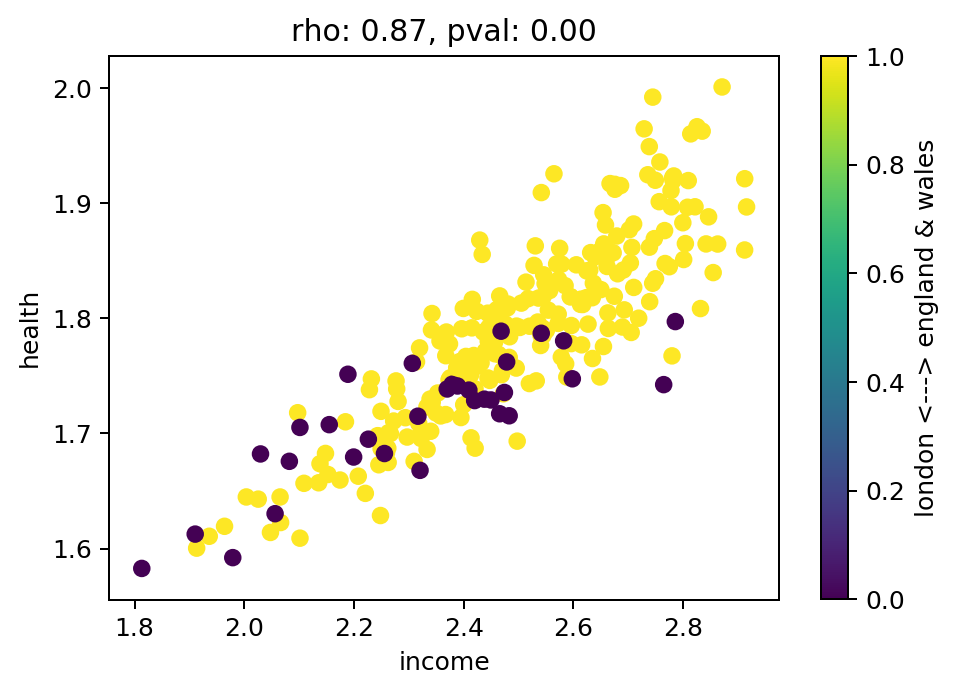

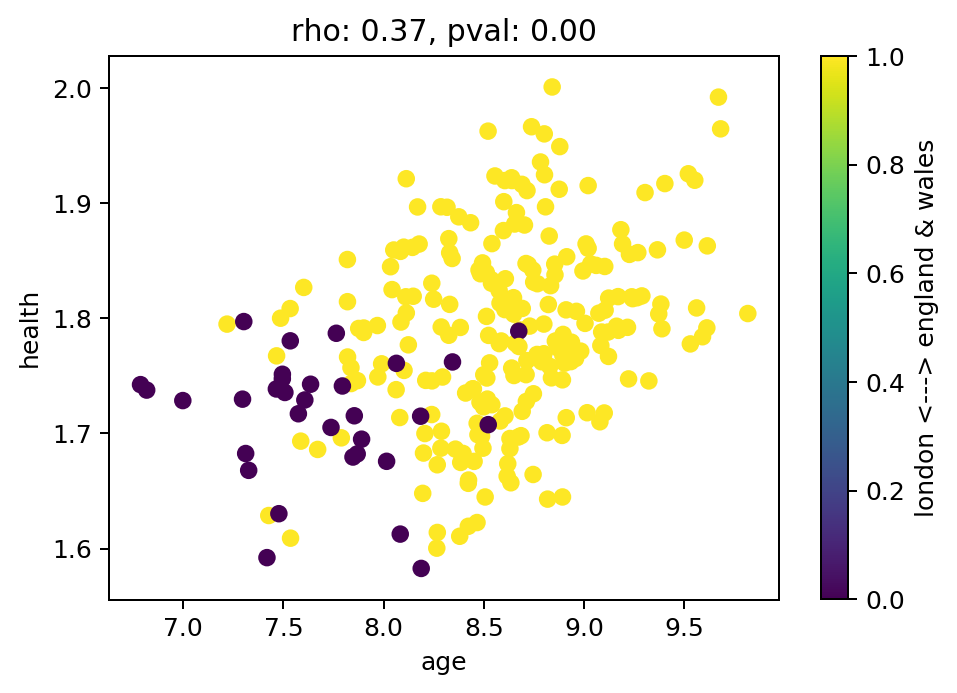

In [66]:
plot_scatter(income_by_geo.values.flatten(), health_by_geo.values.flatten(), [0 if i in lon_geo_dict else 1 for i in ew_geo_dict], xlab='income', ylab='health', zlab='london <---> england & wales')
plot_scatter(age_by_geo.values.flatten(), health_by_geo.values.flatten(), [0 if i in lon_geo_dict else 1 for i in ew_geo_dict], xlab='age', ylab='health', zlab='london <---> england & wales')

Therefore, var SAS clearly does a better job of relating to health than age alone, but not as good a job as income alone. It might be a good idea to plot these 3 variables themselves together, to see how they appear to be related.

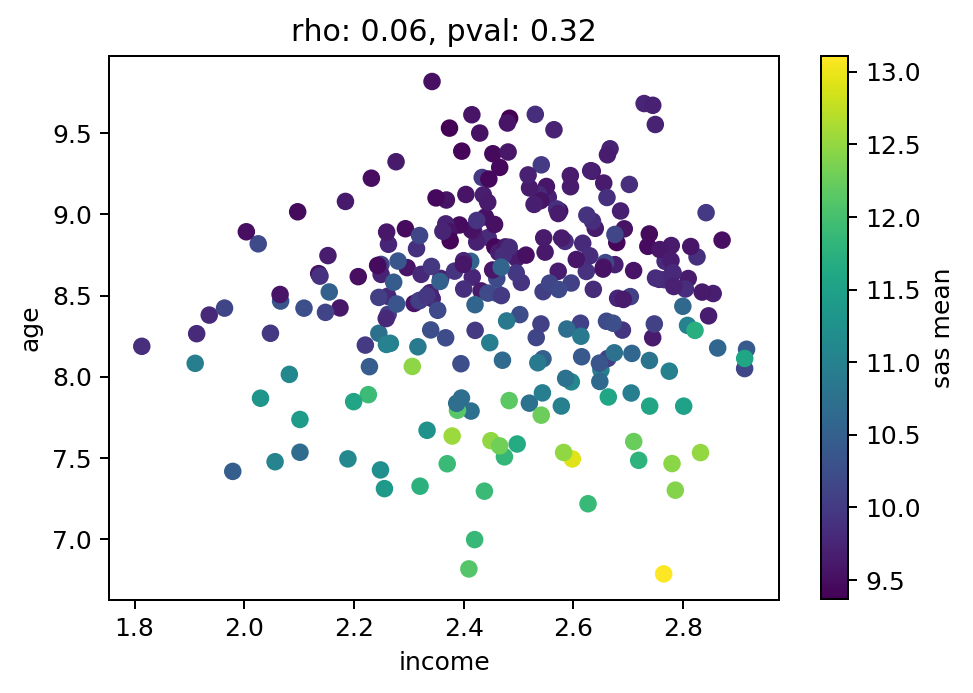

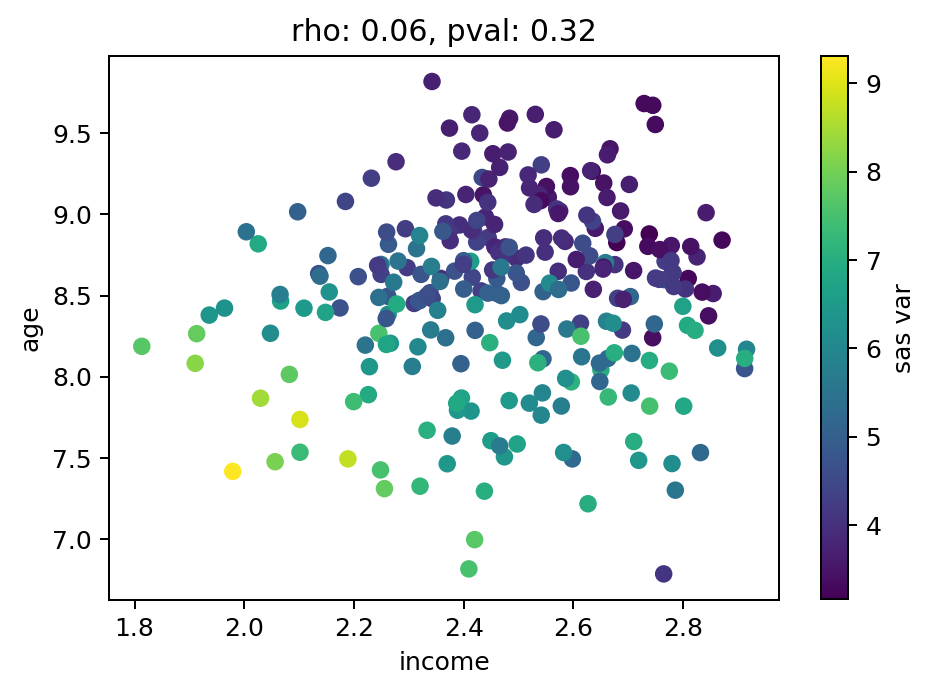

In [65]:
plot_scatter(income_by_geo.values.flatten(), age_by_geo.values.flatten(), sas_full_uk['sas_mean'], xlab='income', ylab='age', zlab='sas mean')
plot_scatter(income_by_geo.values.flatten(), age_by_geo.values.flatten(), sas_full_uk['sas_var'], xlab='income', ylab='age', zlab='sas var')

Clearly, we see that while mean SAS correlates with age and not with income, var SAS seems to correlate with both age and income. This becomes more evident when we change the ordering of the axes, as done below.

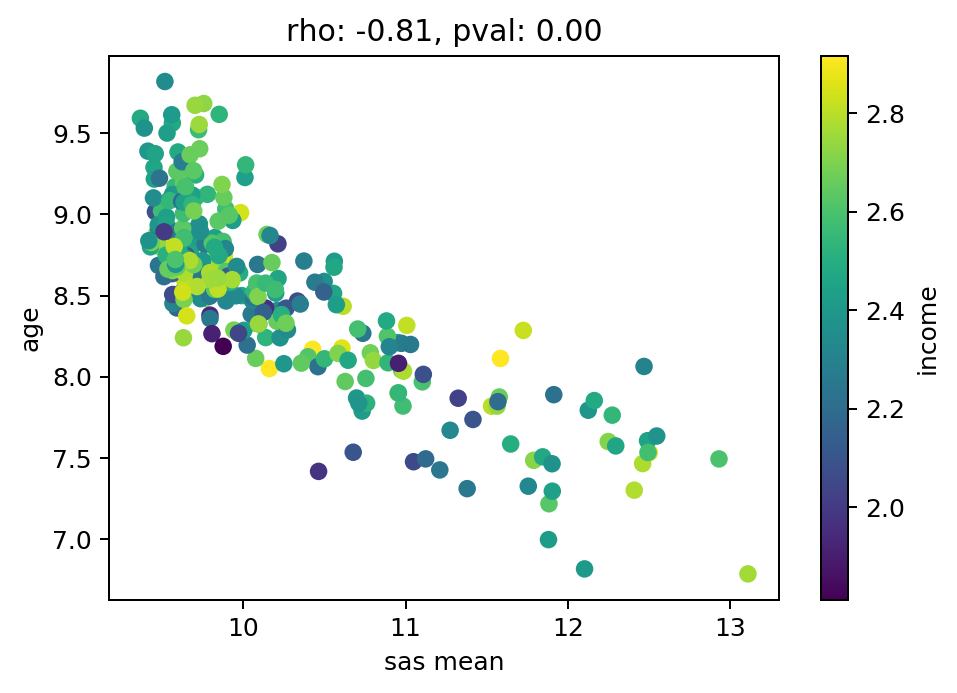

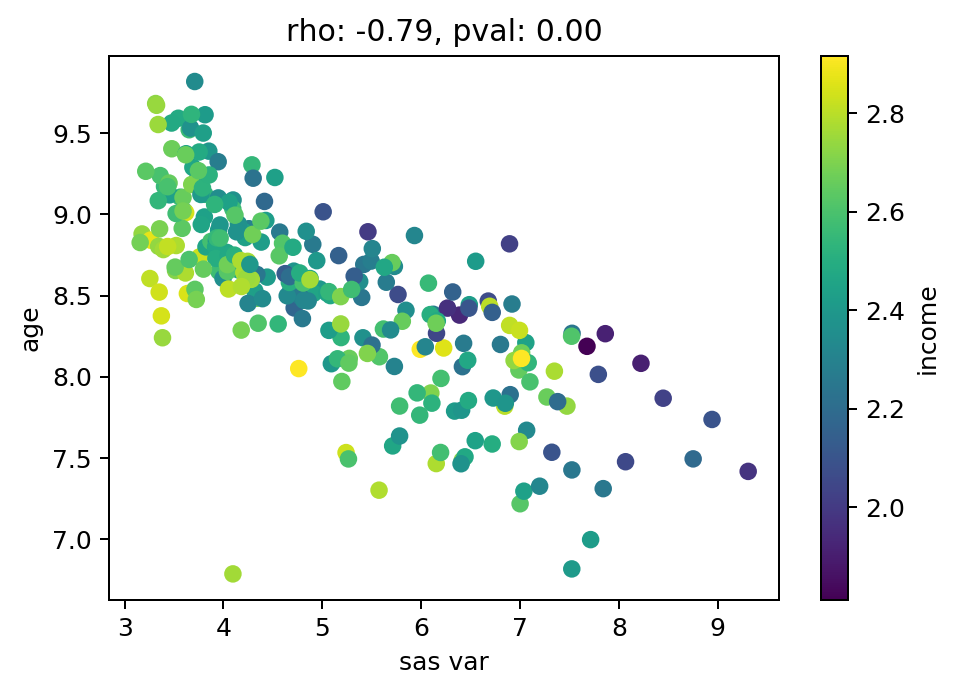

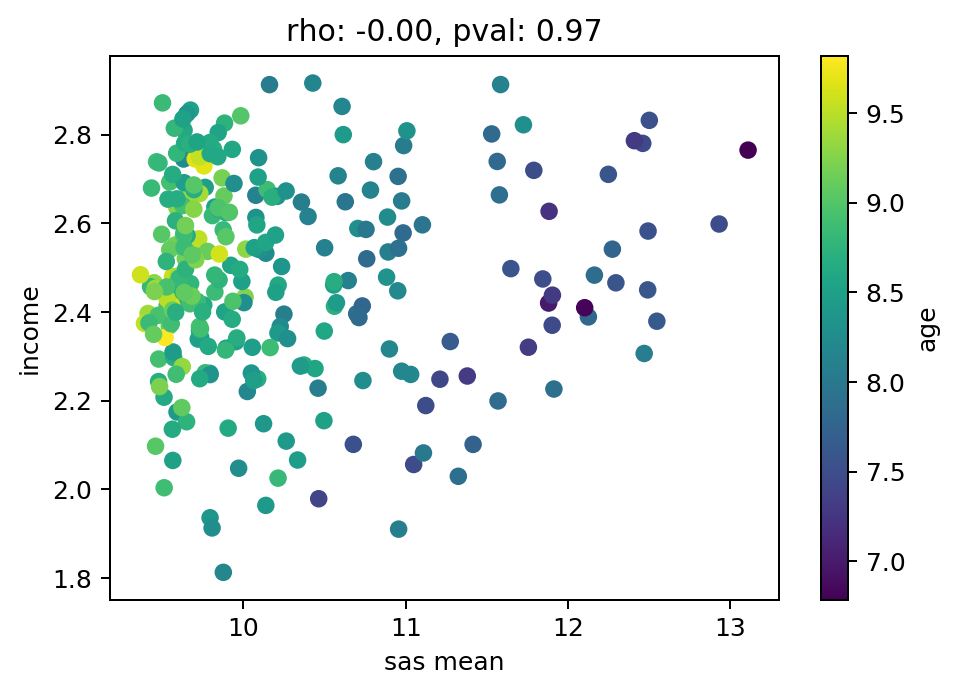

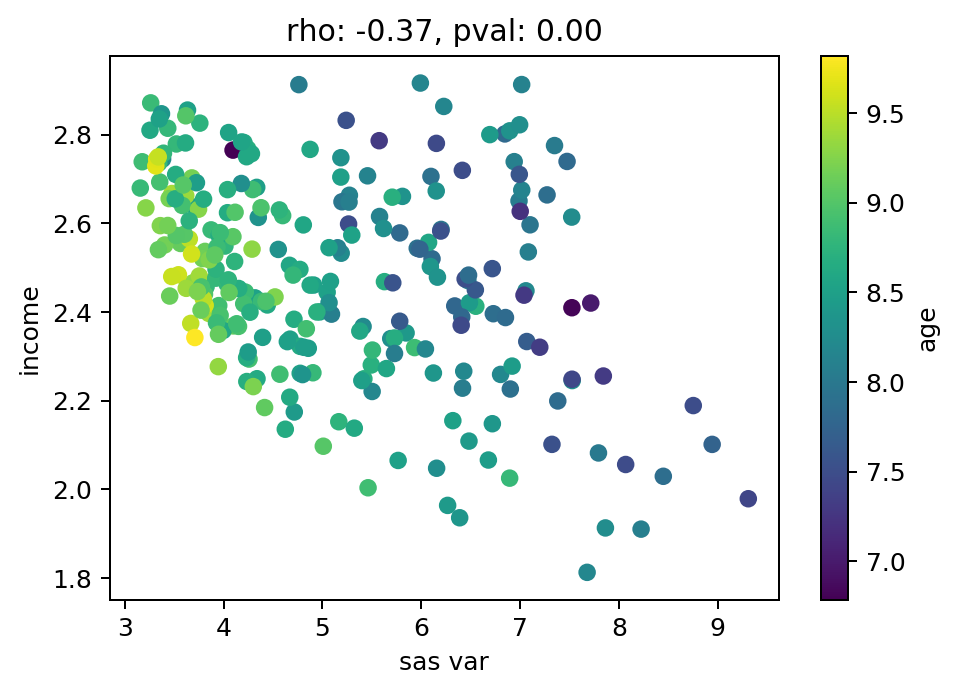

In [64]:
plot_scatter(sas_full_uk['sas_mean'], age_by_geo.values.flatten(), income_by_geo.values.flatten(), xlab='sas mean', ylab='age', zlab='income')
plot_scatter(sas_full_uk['sas_var'], age_by_geo.values.flatten(), income_by_geo.values.flatten(), xlab='sas var', ylab='age', zlab='income')
plot_scatter(sas_full_uk['sas_mean'], income_by_geo.values.flatten(), age_by_geo.values.flatten(), xlab='sas mean', ylab='income', zlab='age')
plot_scatter(sas_full_uk['sas_var'], income_by_geo.values.flatten(), age_by_geo.values.flatten(), xlab='sas var', ylab='income', zlab='age')

This provides an interesting interpretation. While the mean SAS is almost entirely capturing people's **age** (as before?), a higher-order moment such as var SAS is capturing people's **income** as well, which happens to be more correlated to people's perception of general health. 

Let us invert var SAS and look at it as "precision SAS".

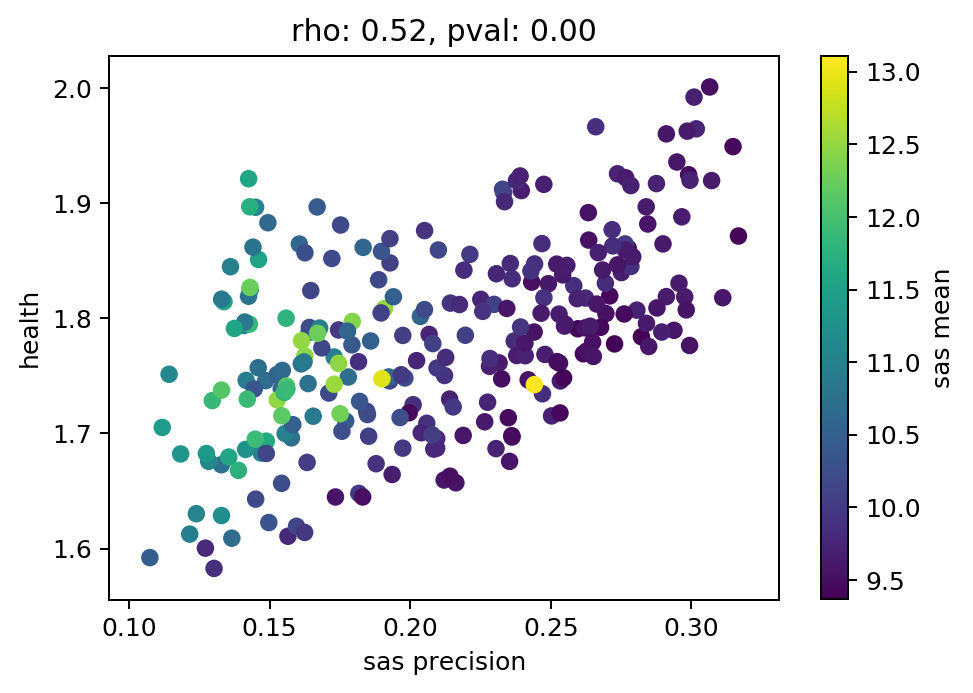

In [78]:
plot_scatter(1/sas_full_uk['sas_var'], health_by_geo, sas_full_uk['sas_mean'], xlab='sas precision', ylab='health', zlab='sas mean')

Now to test how predictive SAS is of health, with and without other predictors such as income or age, we write a function to perform multiple Bayesian linear regression. This function would also compute a [commonality coefficient](https://journals.sagepub.com/doi/10.1177/1094428113493929), which can decouple the *unique* and *shared* contributions of predictors in explaining the observed variance ($R^2$ value).

In [79]:
def regression(X, y, commonality=True):
    if isinstance(X, list):
        for i in range(len(X)):
            try: X[i] = X[i].values
            except: pass
            if len(X[i].shape)==1: X[i] = X[i].reshape(-1,1)
        from numpy import hstack
        X = hstack(X)
    try: X = X.values
    except: pass
    try: y = y.values
    except: pass    
    if len(X.shape)==1: X = X.reshape(-1,1)
    y = y.ravel()
    from sklearn import linear_model, preprocessing
    reg = linear_model.ARDRegression()
    X = preprocessing.scale(X) #standardize independent variables
    y = preprocessing.scale(y) #optionally standardizing dependant variable
    reg.fit(X, y)
    r_sqr = reg.score(X, y)
    out = {'beta':reg.coef_, 'beta_covariance':reg.sigma_, 'beta_precision':reg.lambda_, 'epsilon_precision':reg.alpha_, 'R^2':r_sqr}
    if commonality and X.shape[1]==2:
        #https://journals.sagepub.com/doi/10.1177/1094428113493929
        tmp_1 = regression(X[:,0], y)
        tmp_2 = regression(X[:,1], y)
        gam_1 = r_sqr - tmp_2['R^2']
        gam_2 = r_sqr - tmp_1['R^2']
        gam_12 = tmp_1['R^2'] + tmp_2['R^2'] - r_sqr
        out['commonality'] = {'gam_1':gam_1, 'gam_2':gam_2, 'gam_12':gam_12, 'R^2_1':tmp_1['R^2'], 'R^2_2':tmp_2['R^2']}
    return out

First, let's see how well income and age can predict people's perceived health.

In [84]:
regression([income_by_geo, age_by_geo], health_by_geo)

{'beta': array([0.84688164, 0.30569779]),
 'beta_covariance': array([[ 5.75810776e-04, -4.00442035e-05],
        [-4.00442035e-05,  5.72777410e-04]]),
 'beta_precision': array([ 1.39317506, 10.63538547]),
 'epsilon_precision': 6.580277108023948,
 'R^2': 0.849173706970881,
 'commonality': {'gam_1': 0.7146988347945725,
  'gam_2': 0.0941053116628402,
  'gam_12': 0.040369560513468294,
  'R^2_1': 0.7550683953080408,
  'R^2_2': 0.1344748721763085}}

The overall $R^2$ value is 0.84, with contributions of 0.71, 0.09 and 0.04 from income, age and income-age-shared respectively. Let us see what we obtain when we use mean SAS and precision SAS.

In [85]:
regression([sas_full_uk['sas_mean'], 1/sas_full_uk['sas_var']], health_by_geo)

{'beta': array([0.3071446 , 0.75731346]),
 'beta_covariance': array([[0.00452384, 0.00313356],
        [0.00313356, 0.00461663]]),
 'beta_precision': array([10.11487945,  1.72967403]),
 'epsilon_precision': 1.5361767860794766,
 'R^2': 0.3538141657396715,
 'commonality': {'gam_1': 0.054765164984204584,
  'gam_2': 0.30915011533386116,
  'gam_12': -0.010101114578394244,
  'R^2_1': 0.04466405040581034,
  'R^2_2': 0.2990490007554669}}

We obtain a much lower overall $R^2$ of 0.35, with contributions of 0.05, 0.31 and -0.01 from mean SAS, precision SAS and mean-precision-SAS-shared respectively. Interestingly, a negative shared contribution suggests there is a suppresive interplay. (Note that we are performing *linear* regression, and are presently not exploring a non-linear relationship, which could be more likely given the plots we saw above.)

Since precision SAS seems more useful, let us see if it adds any predictive power to income, and age, separately.

In [81]:
regression([income_by_geo, 1/sas_full_uk['sas_var']], health_by_geo)

{'beta': array([0.77436322, 0.23424048]),
 'beta_covariance': array([[ 0.0008902 , -0.00035104],
        [-0.00035104,  0.00087946]]),
 'beta_precision': array([ 1.66519963, 17.93714043]),
 'epsilon_precision': 5.024650435025851,
 'R^2': 0.8024702514631741,
 'commonality': {'gam_1': 0.5034212507077072,
  'gam_2': 0.04740185615513326,
  'gam_12': 0.25164714460033366,
  'R^2_1': 0.7550683953080408,
  'R^2_2': 0.2990490007554669}}

This time, we obtain an $R^2$ value of 0.8, with contributions of 0.5, 0.05 and 0.25 from income, precision SAS and income-precision-SAS-shared. The low unique contribution of precision SAS suggests that it doesn't cover much newer variation in observed data.

Now with age, we see the following.

In [83]:
regression([age_by_geo, 1/sas_full_uk['sas_var']], health_by_geo)

{'beta': array([-0.02909867,  0.56410878]),
 'beta_covariance': array([[ 0.00188449, -0.00140502],
        [-0.00140502,  0.00367565]]),
 'beta_precision': array([364.75830239,   3.10418165]),
 'epsilon_precision': 1.4241387041233866,
 'R^2': 0.30125906276957126,
 'commonality': {'gam_1': 0.0022100620141043414,
  'gam_2': 0.16678419059326277,
  'gam_12': 0.13226481016220415,
  'R^2_1': 0.1344748721763085,
  'R^2_2': 0.2990490007554669}}

This time, we obtain an $R^2$ value of 0.301, with contributions of 0.002, 0.167 and 0.132 from age, precision SAS and age-precision-SAS-shared. This further concretizes the fact that precision-SAS is able to explain away more unique variance than age alone.

## Next Steps

We need to look at broader indicators of people's health, both physical and mental, perceived and verified. For that purpose, we can look at some NHS datasets which provide us aggregate data on health at various geographical scales--particularly the NHS Commission Groups, which correspond to LAs.

1. [monthly reports](https://digital.nhs.uk/data-and-information/publications/statistical/mental-health-services-monthly-statistics/final-december-2018-provisional-january-2019) data.
2. [annual reports](https://digital.nhs.uk/data-and-information/publications/statistical/mental-health-bulletin/mental-health-bulletin-annual-report-from-mhmds-returns-england-2011-12-further-analysis-and-organisation-level-data)
3. See the [ODS codes](https://digital.nhs.uk/services/organisation-data-service/data-downloads), especially [ONS](https://digital.nhs.uk/services/organisation-data-service/data-downloads/office-for-national-statistics-data) for NHS to LA codings.